# YOLO in PyTorch

Before you delve into this notebook we have to point out, that this is by far the most involved project that we have covered so far. It will require some time and patience to work throught the notebook, but on the other hand you might learn a lot working through the notebook. 

This is a complete end-to-end project. We download the data using a shell script, we prepare the data with python and we use PyTorch to train a YOLO model. This is very similar to what you will be doing in practice. 

We start by downloading the [PASCAL Visual Object Classes dataset](http://host.robots.ox.ac.uk/pascal/VOC/), the same dataset that was used in the original paper YOLO paper. This dataset was used in the object classification and image segmentation challenges, up to 2012. Nowadays the [Coco Dataset](https://cocodataset.org) is the standard dataset to train object detection models, but for educational purposes we will stick to the VOC data.

We use a `bash` script to download and extract the data, but python would also have been a good choice for the same task. 

You will notice that we download 3 datasets. The 2012 training/validation dataset, the 2007 training/validation dataset and the 2007 test dataset. The 2012 dataset contains the training and validation data for the challenges between 2008 and 2012, therefore we have to download the 2007 data separately. Moreover only the 2007 test data has been published. 

In [ ]:
TRAIN = True
assert torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pathlib
weight_path = pathlib.Path('/content/gdrive/MyDrive/weights')

In [ ]:
%%bash
#!/usr/bin/bash

# these are the links of the official VOC competition
link_2012=http://host.robots.ox.ac.uk/pascal/VOC/voc2012/
link_2007=http://host.robots.ox.ac.uk/pascal/VOC/voc2007/

trainval_2012_file=VOCtrainval_11-May-2012.tar
trainval_2007_file=VOCtrainval_06-Nov-2007.tar
test_2007_file=VOCtest_06-Nov-2007.tar

# DOWNLOAD SECTION
# check if files already exis and download the files
if [ -f $trainval_2012_file ]; then
  echo "File $trainval_2012_file already exists, skipping download"
else 
  echo "Downloading ${trainval_2012_file}"
  wget $link_2012$trainval_2012_file
fi

if [ -f $trainval_2007_file ]; then
  echo "File $trainval_2007_file already exists, skipping download"
else 
  wget $link_2007$trainval_2007_file
fi

if [ -f $test_2007_file ]; then
  echo "File $test_2007_file already exists, skipping download"
else 
  wget $link_2007$test_2007_file
fi

# UNPACK SECTION 
if [ -d test_2007 ]; then
  echo "Directory already exists, overwriting"
  rm -rf test_2007
fi
mkdir test_2007
tar xf VOCtest_06-Nov-2007.tar --strip-components=2 -C test_2007/

if [ -d train_val_2007 ]; then
  echo "Directory already exists, overwriting"
  rm -rf train_val_2007
fi
mkdir train_val_2007
tar xf VOCtrainval_06-Nov-2007.tar --strip-components=2 -C train_val_2007/

if [ -d train_val_2012 ]; then
  echo "Directory already exists, overwriting"
  rm -rf train_val_2012
fi
mkdir train_val_2012
tar xf VOCtrainval_11-May-2012.tar --strip-components=2 -C train_val_2012


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



File VOCtrainval_11-May-2012.tar already exists, skipping download
File VOCtrainval_06-Nov-2007.tar already exists, skipping download
File VOCtest_06-Nov-2007.tar already exists, skipping download
Directory already exists, overwriting
Directory already exists, overwriting
Directory already exists, overwriting


In the next step we preprocess the downloaded data. The box coordinates are located in separate xml file, so we read in those files and scale the values, such that the x,y, width and height are all relative to the image size and between 0 and 1. Our approach is very similar to that of [Joseph Redmon](https://pjreddie.com/). Joseph Redmon is one of the original authors of the YOLO paper and has provided shell and python scripts on his website, which detail how the data processing was done for YOLO.

In [ ]:
import pathlib
import os
import shutil
import xml.etree.ElementTree as ET

# input and output folders
folders = [
    ("test_2007", "test"),
    ("train_val_2007", "val"),
    ("train_val_2012", "train"),
]

classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]


def convert(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)


for folder in folders:
    in_root = pathlib.Path(folder[0])
    out_root = pathlib.Path(folder[1])

    # create output folder
    if os.path.exists(out_root):
        shutil.rmtree(out_root)
    os.makedirs(out_root / "images")

    # read in all xml files and extract the bounding box information
    with open(out_root / "config.txt", "a") as f:
        files = os.listdir(in_root / "Annotations")
        for file in files:
            # prepare the config file
            tree = ET.parse(in_root / "Annotations" / file)
            root = tree.getroot()
            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            text = ""
            for obj in root.iter("object"):
                difficult = obj.find("difficult").text
                cls = obj.find("name").text
                if cls not in classes or int(difficult) == 1:
                    continue
                cls_id = classes.index(cls)
                xmlbox = obj.find("bndbox")
                bbox = (
                    float(xmlbox.find("xmin").text),
                    float(xmlbox.find("xmax").text),
                    float(xmlbox.find("ymin").text),
                    float(xmlbox.find("ymax").text),
                )
                text += (
                    str(cls_id)
                    + " "
                    + " ".join([str(a) for a in convert((width, height), bbox)])
                    + " "
                )

            img_name = file.split(".")[0] + ".jpg"
            f.write(img_name + " " + text + "\n")

            # copy the image
            shutil.copy(in_root / "JPEGImages" / img_name, out_root / "images")

We end up with three relevant folders: `train`, `val` and `test`. 

In [ ]:
!ls -la

total 2842536
drwxr-xr-x 1 root root       4096 Aug 29 07:09 .
drwxr-xr-x 1 root root       4096 Aug 29 06:59 ..
drwxr-xr-x 4 root root       4096 Aug 15 13:44 .config
drwx------ 5 root root       4096 Aug 29 07:07 gdrive
drwxr-xr-x 1 root root       4096 Aug 15 13:44 sample_data
drwxr-xr-x 3 root root       4096 Aug 29 07:09 test
drwxr-xr-x 7 root root       4096 Aug 29 07:09 test_2007
drwxr-xr-x 3 root root       4096 Aug 29 07:09 train
drwxr-xr-x 7 root root       4096 Aug 29 07:09 train_val_2007
drwxr-xr-x 7 root root       4096 Aug 29 07:09 train_val_2012
drwxr-xr-x 3 root root       4096 Aug 29 07:09 val
-rw-r--r-- 1 root root  451020800 Jan  1  2019 VOCtest_06-Nov-2007.tar
-rw-r--r-- 1 root root  460032000 Jan  1  2019 VOCtrainval_06-Nov-2007.tar
-rw-r--r-- 1 root root 1999639040 Jan  1  2019 VOCtrainval_11-May-2012.tar


Each of the folders has an `images` subfolder that contains the jpg images and the `config.txt` that we prepared before.

In [ ]:
!ls -la train

total 2680
drwxr-xr-x 3 root root    4096 Aug 29 07:09 .
drwxr-xr-x 1 root root    4096 Aug 29 07:09 ..
-rw-r--r-- 1 root root 2181659 Aug 29 07:09 config.txt
drwxr-xr-x 2 root root  544768 Aug 29 07:09 images


The `config.txt` file contains an entry for each of the images. Each entry consists of the name of the file and the relative x, y, w, h values.

In [ ]:
!head -1 train/config.txt

2011_000268.jpg 2 0.451 0.5673652694610779 0.154 0.2904191616766467 2 0.635 0.6092814371257486 0.334 0.44610778443113774 


Using those directories we can create a PyTorch dataset. The dataset returns an image tensor and a target tensor. 

- The image tensor is a 3x448x448 tensor, that is used as the input to our model. 

- The target is a 7x7x30 tensor, consisting of two bounding boxes (pr, x, y, w, h) and 20 class probabilities. The x and y values are relative to the grid cell that contain them and the w and h values are relative to the whole image. 

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import pathlib
from PIL import Image

train_path = pathlib.Path("train")
val_path = pathlib.Path("val")
test_path = pathlib.Path("test")

class PascalVOC(Dataset):
    def __init__(self, dataset_type, img_size=448, S=7, B=2, C=20):
        if dataset_type == "train":
            self.root = train_path
        elif dataset_type == "val":
            self.root = val_path
        elif dataset_type == "test":
            self.root = test_path

        self.img_size = img_size
        self.S = S
        self.B = B
        self.C = C

        self.lines = []
        # open configuration file and format the data
        with open(self.root / "config.txt") as f:
            lines = f.readlines()

        for line in lines:
            self.lines.append(line.strip().split())

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        line = self.lines[idx]

        # prepare image
        transforms = T.Compose(
            [T.Resize(size=(self.img_size, self.img_size)), T.ToTensor()]
        )
        img_path = self.root / "images" / line[0]
        img = Image.open(img_path)
        img = transforms(img)

        # prepare targets
        # we have to create a [SxSx5xB+C] Tensor
        
        S, B, C = self.S, self.B, self.C 
        N = 5 * B + C
        target = torch.zeros(S, S, N)

        boxes = line[1:]
        for obj in range(len(boxes) // 5):
            box = boxes[obj*5:(obj+1)*5]
            label, x, y, width, height = box

            # transform data from string to numbers
            label = int(label)
            x = float(x)
            y = float(y)
            width = float(width)
            height = float(height)

            # row, column position ob center
            i, j = int(S * y), int(S * x) 
            x_relative, y_relative = S * x - j, S * y - i 

            # target
            for b in range(B):
                start = 5 * b
                target[i, j, start] = 1.0
                target[i, j, start+1] = x_relative
                target[i, j, start+2] = y_relative
                target[i, j, start+3] = width
                target[i, j, start+4] = height
            target[i, j, 5*B + label] = 1.0

        return img, target


The model itself is not complicated, but requires some patience to type out. You should compare the configuration to the one in the YOLO paper

In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, bias=False, **kwargs),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(negative_slope=0.1),
        )

    def forward(self, x):
        return self.block(x)


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # Part 1
            BasicBlock(
                in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3
            ),
            nn.MaxPool2d(kernel_size=2),
            # Part 2
            BasicBlock(
                in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1
            ),
            nn.MaxPool2d(kernel_size=2),
            # Part 3
            BasicBlock(
                in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
            ),
            nn.MaxPool2d(kernel_size=2),
            # Part 4
            BasicBlock(
                in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1
            ),
            nn.MaxPool2d(kernel_size=2),
            # Part 5
            BasicBlock(
                in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0
            ),
            BasicBlock(
                in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1
            ),
            nn.MaxPool2d(kernel_size=2),
            # Part 6
            BasicBlock(
                in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1
            ),
            BasicBlock(
                in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1
            ),
            # Part 7
            nn.Flatten(),
            nn.Linear(in_features=7*7*1024, out_features=4096),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.5),
            # Part 8
            nn.Linear(in_features=4096, out_features=7*7*30),
            # we need to scale the outputs between 0 and 1
            nn.Sigmoid()
        )

    def predict(self, x):
      self.eval()
      with torch.inference_mode():
        x = self.layers(x)
        x = x.view(-1, 7, 7, 30)
      self.train()
      return x

    def forward(self, x):
        x = self.layers(x)
        # We reshape using the following form (N, S, S, 5 * B + C)
        # 5 is due to Pr., x, y, w, h
        # N = Batch Size
        # S = Grid Size
        # B = Number of Boxes = 2 
        # C = Number of CLasses = 20
        x = x.view(-1, 7, 7, 30)
        return x
     

In [ ]:
import torch.nn.functional as F

class YoloLoss(nn.Module):
    def __init__(
        self,
        S=7,
        B=2,
        C=20,
        lambda_coord=5.0,
        lambda_noobj=0.5,
    ):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    # intersection over union
    def calc_iou(self, bbox1, bbox2):
        # bbox has format [batch_size, S, S, 4], where 4 includes x1, y1, x2, y2

        left_coordinate = torch.maximum(bbox1[..., :2], bbox2[..., :2])

        right_coordinate = torch.minimum(bbox1[..., 2:], bbox2[..., 2:])

        width_height = (right_coordinate - left_coordinate).clamp(0)
        area1 = (bbox1[..., 2] - bbox1[..., 0]) * (bbox1[..., 3] - bbox1[..., 1])
        area2 = (bbox2[..., 2] - bbox2[..., 0]) * (bbox2[..., 3] - bbox2[..., 1])

        intersection = width_height[..., 0] * width_height[..., 1]
        union = area1 + area2 - intersection
        iou = intersection / union
        return iou

    def calc_coordinates(self, prediction, target):
        coordinates_collection = []

        for b in range(self.B):
            coordinates = []
            for tensor in [prediction, target]:
                start = b * 5
                center = tensor[:, :, :, start + 1 : start + 3]
                dimensions = tensor[:, :, :, start + 3 : start + 5]

                x1 = (center[..., 0] - 0.5 * dimensions[..., 0]).unsqueeze(3)
                y1 = (center[..., 1] - 0.5 * dimensions[..., 1]).unsqueeze(3)
                x2 = (center[..., 0] + 0.5 * dimensions[..., 0]).unsqueeze(3)
                y2 = (center[..., 1] + 0.5 * dimensions[..., 1]).unsqueeze(3)

                bbox = [x1, y1, x2, y2]
                bbox = torch.cat(bbox, dim=3)
                coordinates.append(bbox)
            coordinates_collection.append(coordinates)
        return coordinates_collection

    def forward(self, prediction, target):
        # prediction and target have the following shape
        # [batch_size, S, S, (prob, x, y, w, h)*B+C],

        S, B, C = self.S, self.B, self.C
        N = 5 * B + C

        # first calculate IOUs
        ious = []
        coordinates_collection = self.calc_coordinates(prediction, target)
        for coordinates in coordinates_collection:
            iou = self.calc_iou(coordinates[0], coordinates[1])
            ious.append(iou.unsqueeze(0))

        ious = torch.cat(ious)
        max_ious, max_idxs = ious.max(dim=0)

        # mask to determine which box is more useful
        box_mask = max_idxs.unsqueeze(dim=-1)

        obj_mask = (target[..., 1] > 0).unsqueeze(dim=-1)
        noobj_mask = (target[..., 1] == 0).unsqueeze(dim=-1)

        obj_prediction = obj_mask * prediction
        noobj_prediction = noobj_mask * prediction

        obj_target = obj_mask * target
        noobj_target = noobj_mask * target

        # ========================== #
        # coordinates loss
        # ========================== #
        box_prediction = (
            obj_prediction[..., 1:5] * (1 - box_mask)
            + obj_prediction[..., 6:10] * box_mask
        )

        box_target = (
            obj_target[..., 1:5] * (1 - box_mask) + obj_target[..., 6:10] * box_mask
        )
        box_prediction[..., 2:4] = torch.sqrt(box_prediction[..., 2:4] + 1e-8) 
        box_target[..., 2:4] = torch.sqrt(box_target[..., 2:4])
        loss_coord = F.mse_loss(box_prediction, box_target, reduction="sum")

        # ========================== #
        # confidence loss: no object
        # ========================== #
        confidence_pred_noobj = noobj_prediction[..., 0:1] + noobj_prediction[..., 5:6]
        confidence_target_noobj = noobj_target[..., 0:1] + noobj_target[..., 5:6]
        loss_noobj_conf = F.mse_loss(confidence_pred_noobj, confidence_target_noobj, reduction="sum")

        # ========================== #
        # confidence loss: with object
        # ========================== #
        confidence_pred_obj = (
            obj_prediction[..., 0:1] * (1 - box_mask)
            + obj_prediction[..., 5:6] * box_mask
        )
        confidence_target_obj = (
            obj_target[..., 0:1] * (1 - box_mask) + obj_target[..., 5:6] * box_mask
        )
        loss_obj_conf = F.mse_loss(confidence_pred_obj, confidence_target_obj, reduction="sum")

        # ========================== #
        # classificatoin loss
        # ========================== #
        class_pred = obj_prediction[..., 10:]
        class_target = obj_target[..., 10:]
        loss_class = F.mse_loss(class_pred, class_target, reduction="sum")

        loss = (
            self.lambda_coord * loss_coord
            + loss_obj_conf
            + self.lambda_noobj * loss_noobj_conf
            + loss_class
        )
        return loss



In [ ]:
# make sure that a GPU is available, otherwise the process is going to be very slow
assert torch.cuda.is_available()

In [ ]:
!nvidia-smi

Mon Aug 29 10:29:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# hyperparameters
DEVICE = torch.device("cuda:0")
#BATCH_SIZE = 256
BATCH_SIZE=128
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
# LEARNING_RATE = 1e-2
LEARNING_RATE = 1e-5
NUM_WORKERS = 2
NUM_EPOCHS = 10

In [ ]:
# initialize datasets
train_dataset = PascalVOC(dataset_type="train")
val_dataset = PascalVOC(dataset_type="val")
test_dataset = PascalVOC(dataset_type="test")

In [ ]:
from torch.utils.data import DataLoader

# initialize dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

In [ ]:
def evaluate_performance(dataloader):
  losses = [] 
  with torch.inference_mode():
    for img, target in dataloader:
      img, target = img.to(DEVICE), target.to(DEVICE)
      with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        pred = model(img)
        loss = criterion(pred, target)
      losses.append(loss.item())
  return sum(losses)

In [ ]:
import torch.optim as optim

model = Model().to(DEVICE)
criterion = YoloLoss()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

In [ ]:
import time
# training loop
if TRAIN:
  min_loss = float("inf")
  scaler = torch.cuda.amp.GradScaler()
  for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    losses = [] 
    for img, target in train_dataloader:
        img, target = img.to(DEVICE), target.to(DEVICE)
        optim.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
          pred = model(img)
          loss = criterion(pred, target)
        losses.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    train_loss = sum(losses)
    val_loss = evaluate_performance(val_dataloader)
    end_time = time.time()
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Elapsed Time: {end_time-start_time:.2f}sec')
    if val_loss < min_loss:
      print("Saving Weights")
      min_loss = val_loss
      torch.save(model.state_dict(), weight_path / 'yolo_weights.pt')

In [ ]:
def get_bboxes(target, prob_threshold=.5):
  S=7
  height = 448
  width = 448
  cell_height = height / S
  cell_width = width / S

  mask1 = target[..., 0] > prob_threshold
  mask2 = target[..., 5] > prob_threshold
  mask = torch.cat([mask1.unsqueeze(0), mask2.unsqueeze(0)], dim=0)
  mask, _ = torch.max(mask, dim=0)

  bbox1 = target[..., 1:5]
  bbox2 = target[..., 6:10]

  bbox = torch.cat([bbox1.unsqueeze(0), bbox2.unsqueeze(0)], dim=0)
  bbox, _ = torch.max(bbox, dim=0)

  row_indices = torch.arange(S).unsqueeze(-1)
  col_indices = torch.arange(S).unsqueeze(0)

  x = bbox[..., 0] * cell_width + col_indices * cell_width - (bbox[..., 2] * width) / 2
  y = bbox[..., 1] * cell_height + row_indices * cell_height - (bbox[..., 3] * height) / 2

  width = bbox[..., 2] * width
  height = bbox[..., 3] * height

  x = x*mask
  y = y*mask
  width = width*mask
  height = height*mask
  bboxes = [x.unsqueeze(-1), 
            y.unsqueeze(-1), 
            width.unsqueeze(-1), 
            height.unsqueeze(-1)]
  
  bboxes = torch.cat(bboxes, dim=-1)
  return bboxes

In [ ]:
# draw image and bboxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes(images, bboxes, columns, rows):

  fig = plt.figure(figsize=(20, 20))
  for i in range(1, columns*rows +1):
    # draw image
    img = images[i-1].numpy()
    img = img.transpose(1, 2, 0)
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

    # draw boxes
    idxs = (bboxes[i-1][..., 0] > 0).unsqueeze(-1)
    idxs = idxs.expand(bboxes[i-1].size())
    valid_bboxes = bboxes[i-1][idxs].numpy().reshape(-1, 4)
    for box_idx in range(len(valid_bboxes)):
      x = valid_bboxes[box_idx][0]
      y = valid_bboxes[box_idx][1]
      width = valid_bboxes[box_idx][2]
      height = valid_bboxes[box_idx][3]

      rect = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
      )
      ax.add_patch(rect)
  plt.show()

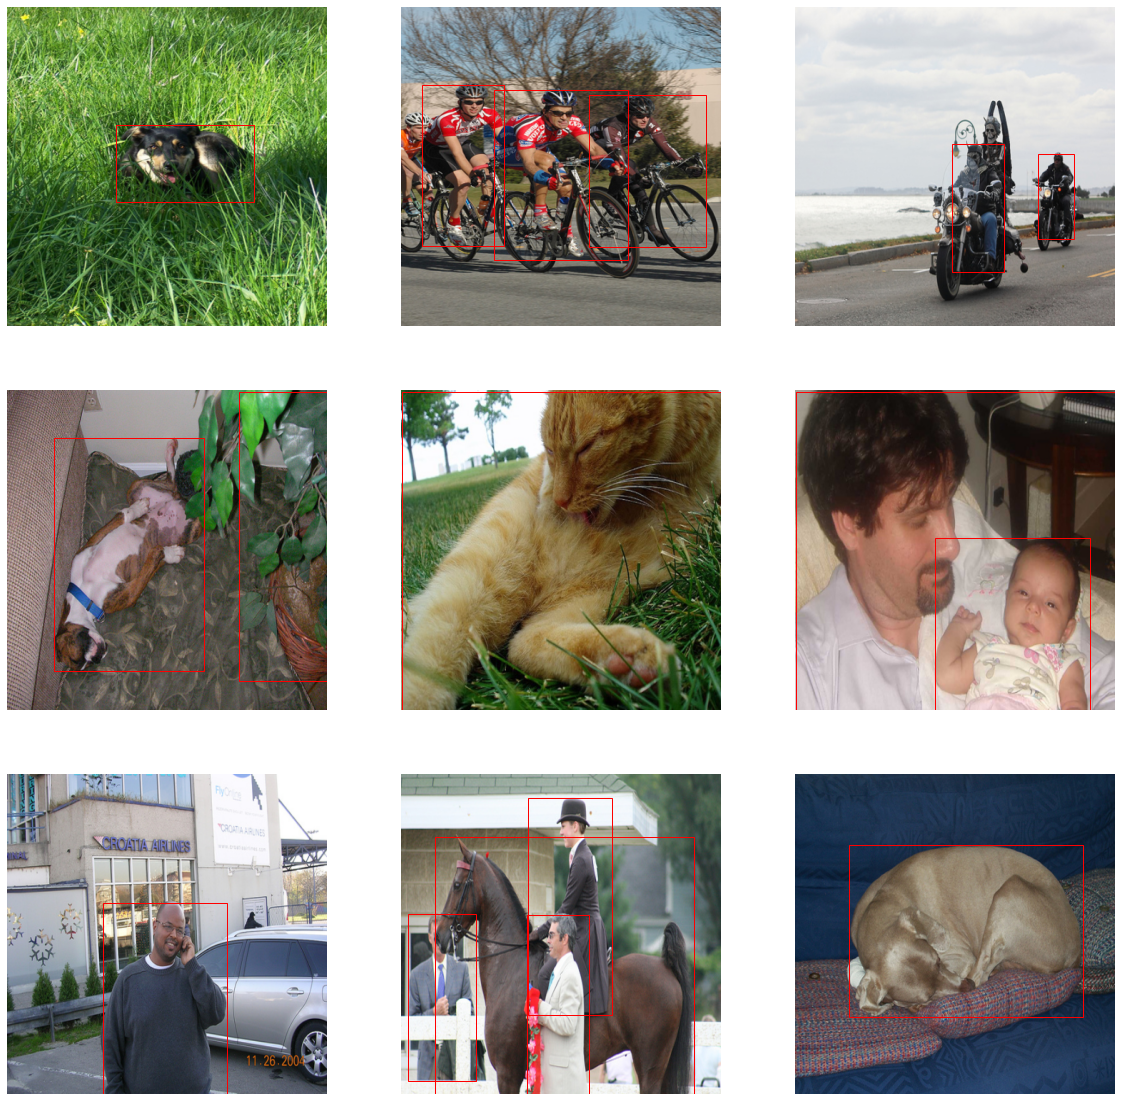

In [ ]:
img, target = next(iter(train_dataloader))
bboxes = get_bboxes(target[:15])
draw_boxes(img[:15], bboxes, 3, 3)


In [ ]:
# show predictions

model = Model().to(DEVICE)
weights = torch.load(weight_path / 'yolo_weights.pt')
model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
img, target = next(iter(val_dataloader))
img = img[:15].to(DEVICE)
labels = model.predict(img)
img = img.cpu()
labels = labels.cpu()
bboxes = get_bboxes(labels, prob_threshold=0.5)

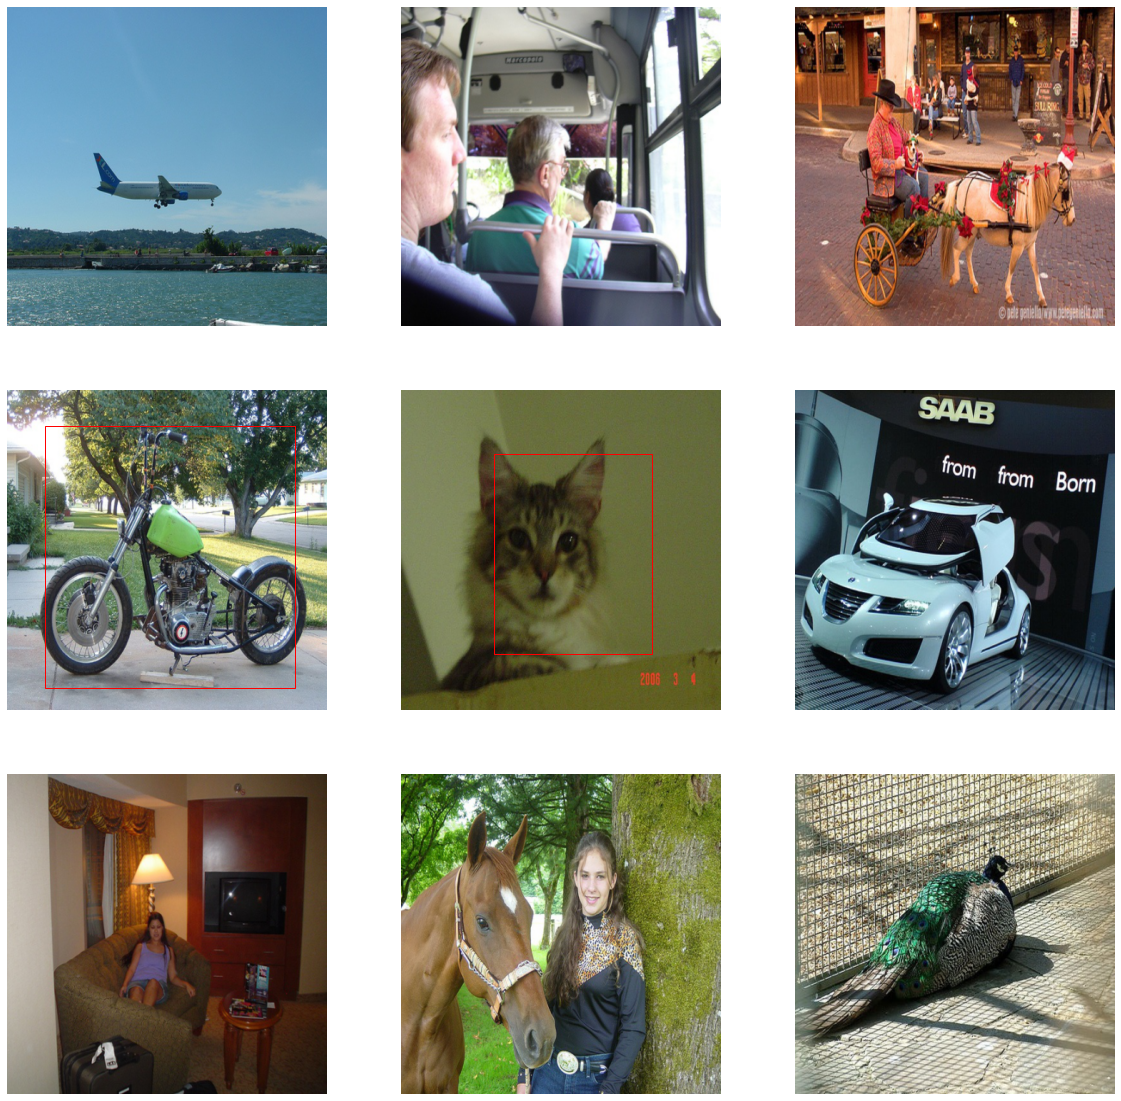

In [ ]:
draw_boxes(img, bboxes, 3, 3)

In [ ]:
print(labels[0][..., 0].max())

tensor(0.1414)
